# It's Corn (PogChamps \#3) Kaggle Competition - Submission 1

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [4]:
path

Path('kaggle-pog-series-s01e03')

In [5]:
import timm
from fastai.vision.all import *
set_seed(42)

path.ls()

(#1) [Path('kaggle-pog-series-s01e03/corn')]

In [6]:
trn_path = path/'corn'/'train'
trn_path.ls()

(#14322) [Path('kaggle-pog-series-s01e03/corn/train/08602.png'),Path('kaggle-pog-series-s01e03/corn/train/06377.png'),Path('kaggle-pog-series-s01e03/corn/train/12836.png'),Path('kaggle-pog-series-s01e03/corn/train/05256.png'),Path('kaggle-pog-series-s01e03/corn/train/03056.png'),Path('kaggle-pog-series-s01e03/corn/train/00938.png'),Path('kaggle-pog-series-s01e03/corn/train/02865.png'),Path('kaggle-pog-series-s01e03/corn/train/02323.png'),Path('kaggle-pog-series-s01e03/corn/train/09385.png'),Path('kaggle-pog-series-s01e03/corn/train/10855.png')...]

In [7]:
tst_path = path/'corn'/'test'
tst_path.ls()

(#3479) [Path('kaggle-pog-series-s01e03/corn/test/02921.png'),Path('kaggle-pog-series-s01e03/corn/test/17570.png'),Path('kaggle-pog-series-s01e03/corn/test/01816.png'),Path('kaggle-pog-series-s01e03/corn/test/07985.png'),Path('kaggle-pog-series-s01e03/corn/test/04347.png'),Path('kaggle-pog-series-s01e03/corn/test/02109.png'),Path('kaggle-pog-series-s01e03/corn/test/09175.png'),Path('kaggle-pog-series-s01e03/corn/test/01604.png'),Path('kaggle-pog-series-s01e03/corn/test/14128.png'),Path('kaggle-pog-series-s01e03/corn/test/01616.png')...]

Grab csv lists

In [8]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
train = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

In [9]:
print(train.head())

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


In [10]:
train['label'].value_counts()

pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64

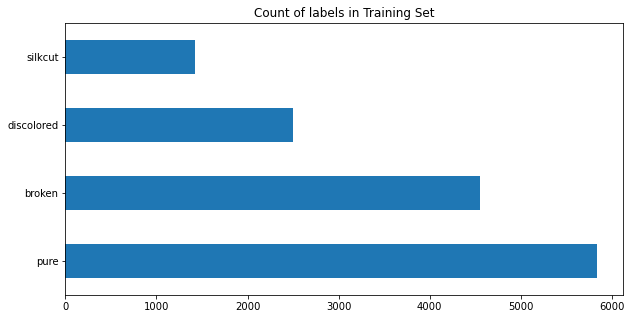

In [11]:
train['label'].value_counts() \
    .plot(kind='barh',
          figsize=(10,5),
          title='Count of labels in Training Set')
plt.show()

## Looking at the data

In [12]:
files = get_image_files(trn_path)

(140, 140)


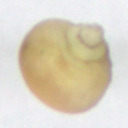

In [13]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

## Check image sizes
Check all the image sizes.  This is faster in parallel.  Using fastcore's `parallel` for this:

In [14]:
print (f"Total number of train images: {len(files)}")

Total number of train images: 14322


In [15]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
# AMD Ryzen 9 5900X 12-Cores / 24-Threads
sizes = parallel(f, files, n_workers=24)
pd.Series(sizes).value_counts()

(132, 132)    187
(140, 136)    187
(136, 132)    168
(136, 136)    166
(128, 132)    165
             ... 
(136, 121)      1
(140, 104)      1
(208, 168)      1
(104, 180)      1
(204, 164)      1
Length: 784, dtype: int64

In [16]:
#help(ImageDataLoaders)

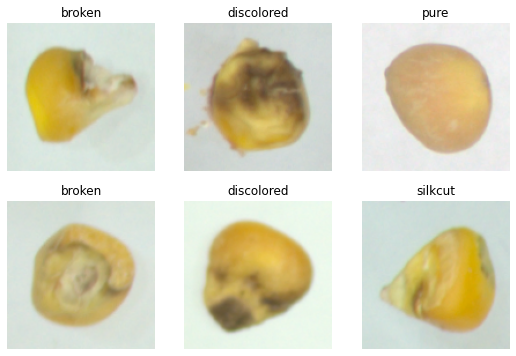

In [17]:
dls = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2, seed=42,
    fn_col=2, label_col=3,
    item_tfms=Resize(128, method='squish'))

dls.show_batch(max_n=6)

## Model Experimentation

Let's experiment with some different architectures and image processing approaches (item and batch transforms).  In order to make this easier lets make a function that takes care of common modelling steps that we can hand different architectures, item transforms and batch transforms to:

In [18]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_csv(csv_path, 
        csv_fname='train.csv', valid_pct=0.2,
        seed=42, fn_col=2, label_col=3,
        item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch,
        metrics=[error_rate,accuracy]).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

Let's try to re-run resnet26d to test

In [19]:
learn = train('resnet26d',
    item=Resize(128, method='squish'),
    batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.187357,1.209728,0.435405,0.564595,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.877270,0.928708,0.371858,0.628142,00:08
1,0.807573,0.915431,0.342528,0.657472,00:08
2,0.694805,0.750602,0.288059,0.711941,00:08
3,0.600717,0.772813,0.302374,0.697626,00:08
4,0.551738,0.743126,0.292249,0.707751,00:08


## A ConvNeXt model

Again looking at [efficient models for fine tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning) `convnext_small` tops the performance/accuracy tradeoff score.  Let's try it!

In [20]:
arch = 'convnext_small_in22k'

learn = train(arch, 
    item=Resize(128, method='squish'),
    batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.050976,1.005719,0.342528,0.657472,00:12


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.704495,0.699570,0.287360,0.712640,00:17
1,0.638026,0.667203,0.256285,0.743715,00:17
2,0.538506,0.550937,0.212989,0.787011,00:17
3,0.434270,0.547480,0.211941,0.788059,00:17
4,0.351854,0.576697,0.212989,0.787011,00:17


Training looks like it was still effective @ 5 epochs.  Accuracy went from ~70% to ~80% while adding ~10 seconds/epoch to the compute time.

## Preprocessing experiments

Let's compare squishing images to the common (128,128) size vs. cropping a (128,128) size.

In [21]:
# ResizeMethod.Crop is default for Resize function
learn = train(arch, item=Resize(128),
    batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.045745,0.893480,0.325070,0.674930,00:12


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.711886,0.731101,0.285265,0.714735,00:17
1,0.623060,0.640027,0.239874,0.760126,00:17
2,0.547414,0.627892,0.240922,0.759078,00:17
3,0.434283,0.547500,0.211592,0.788408,00:17
4,0.359579,0.569942,0.208799,0.791201,00:17


This ended up being a touch worse (not much difference).  We can try padding as well:

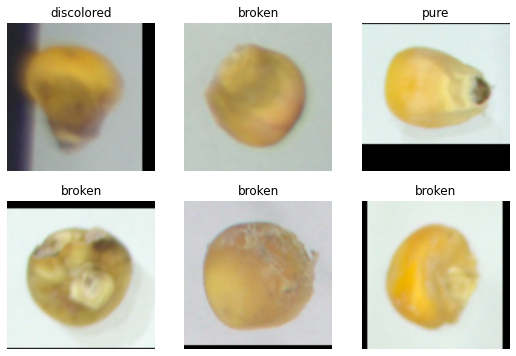

In [22]:
dls = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2, seed=42,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(128,128), min_scale=0.75))

dls.show_batch(max_n=6)

In [23]:
learn = train(arch, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(128,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.049038,0.796102,0.307961,0.692039,00:13


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.720343,0.674011,0.276536,0.723464,00:18
1,0.646697,0.627403,0.245810,0.754190,00:18
2,0.521796,0.597912,0.231844,0.768156,00:18
3,0.437591,0.562013,0.215782,0.784218,00:18
4,0.354162,0.548508,0.205307,0.794693,00:18


Results are again about the same but there is no distortion in the images which may be a positive.  Let's try to keep the resolution.  Should take longer, might be more accurate.

In [24]:
learn = train(arch, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256,256), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.105356,1.276573,0.442039,0.557961,00:32


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.701099,0.754442,0.300978,0.699022,00:43
1,0.621817,0.628406,0.236383,0.763617,00:43
2,0.538959,0.578189,0.231145,0.768855,00:43
3,0.417572,0.557205,0.218226,0.781774,00:43
4,0.336412,0.552245,0.202514,0.797486,00:43


Slightly worse but about the same mix.  All methods are also not saturating (continuously improving).  May need to rerun tests with more epochs to see if they settle at different points.

## Test time augmentation

To make the predictions even better, we can try [test time augmentation]() (TTA).  fastai book defines this as:

> During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

Before trying this, let's check the predictions and error rate of our model without TTA.  Let's choose padding to (256,256) then resampling to (128, 128) as our preprocessing scheme.

In [25]:
learn = train(arch, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(128,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.040943,0.890600,0.329958,0.670042,00:13


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.678555,0.739875,0.288757,0.711243,00:18
1,0.627967,0.633630,0.256634,0.743366,00:18
2,0.521459,0.634577,0.246159,0.753841,00:18
3,0.435038,0.542795,0.217877,0.782123,00:18
4,0.360646,0.544653,0.212290,0.787709,00:18


In [26]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [27]:
error_rate(preds, targs)

TensorBase(0.2123)

In [28]:
accuracy(preds, targs)

TensorBase(0.7877)

That's the same error rate and accuracy in the run above so we know this is done correctly.

Let's take a look at what our data augmentation is doing.

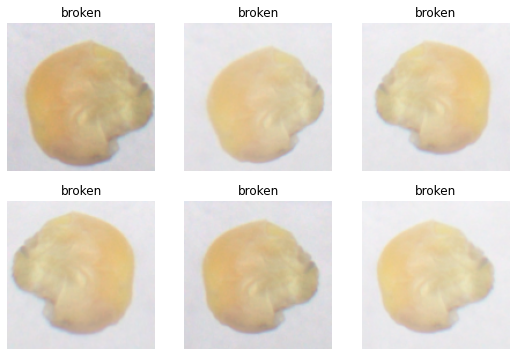

In [29]:
learn.dls.train.show_batch(max_n=6, unique=True)

These images are all rotated, flipped, warped, zoomed, slightly lighter or darker.

If we call tta() then we'll get the average predictiosn made for multiple different augmented versions of each image, along with the unaugmented original:

In [30]:
tta_preds,_ = learn.tta(dl=valid)

Let's check the error rate with TTA:

In [31]:
error_rate(tta_preds, targs)

TensorBase(0.2071)

In [32]:
accuracy(tta_preds, targs)

TensorBase(0.7929)

This seems to make an improvement.  Likely want to add this to submissions we make.  Thinking that some of the augmentations might be pushing features of some images into othe classes (by cropping the damage, making the colour lighter/darker, etc).  May need to look into simpler augmentations.

## Scaling up

Let's try to scale up to larger images and more epochs.  We can switch to keeping (256,256) padded images, with final augmented images:

In [33]:
learn = train(arch, epochs=12, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256,256), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.055425,0.951340,0.351955,0.648045,00:32


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.692252,0.640721,0.261872,0.738128,00:43
1,0.622336,0.621422,0.244763,0.755237,00:43
2,0.578609,0.616603,0.244064,0.755936,00:44
3,0.533659,0.634714,0.239176,0.760824,00:43
4,0.461983,0.719355,0.240223,0.759777,00:43
5,0.376383,0.655313,0.230447,0.769553,00:43
6,0.304899,0.654771,0.216830,0.783170,00:43
7,0.218239,0.818508,0.222416,0.777584,00:43
8,0.166703,0.862893,0.212989,0.787011,00:43
9,0.118591,0.900067,0.207053,0.792947,00:43


Unfortunately, validation loss is jumpy from the beginning and starts showing signs of overfitting well before the 12th iteration.  Let's try making a version of our helper function that uses the auto learning rate finder to set a learning rate that might be better (if conservative).

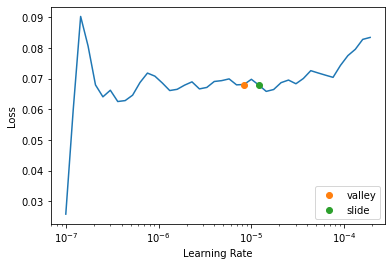

In [34]:
_valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))

In [35]:
def train_auto_loss(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_csv(csv_path, 
        csv_fname='train.csv', valid_pct=0.2,
        seed=42, fn_col=2, label_col=3,
        item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch,
        metrics=[error_rate,accuracy]).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    learn.fine_tune(epochs, _slide)
    return learn

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.120406,0.886563,0.348813,0.651187,00:32


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.747659,0.705801,0.287011,0.712989,00:43
1,0.664571,0.617311,0.249302,0.750698,00:43
2,0.598163,0.603761,0.240922,0.759078,00:43
3,0.539659,0.585328,0.230796,0.769204,00:43
4,0.475773,0.590688,0.223813,0.776187,00:43
5,0.439829,0.595587,0.217179,0.782821,00:43
6,0.372057,0.622161,0.224511,0.775489,00:43
7,0.314425,0.656998,0.228352,0.771648,00:43
8,0.258570,0.672160,0.219972,0.780028,00:43
9,0.222249,0.688088,0.215433,0.784567,00:43


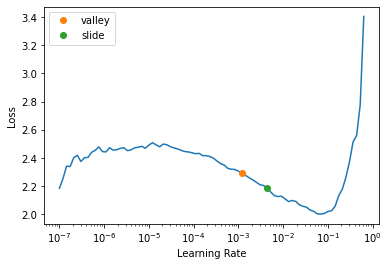

In [36]:
learn = train_auto_loss(arch, epochs=12, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256,256), min_scale=0.75))

In [37]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
accuracy(preds,targs)

TensorBase(0.7853)

In [40]:
tta_preds,targs = learn.tta(dl=valid)
accuracy(tta_preds,targs)

TensorBase(0.7916)

## Submitting to Kaggle

Take a look at the structure of the submission file

In [41]:
ss

,seed_id,label
0,8632,broken
1,11394,broken
2,17362,pure
3,9987,discolored
4,17226,silkcut
...,...,...
3474,1461,pure
3475,2566,discolored
3476,11504,discolored
3477,5140,pure


Doesn't seem to be in any particular order.  Let's still sort our results by seed_id to make it easier to compare/debug!

Let's also check the seed_id => file_name relationship in test

In [42]:
test

,seed_id,view,image
0,2,top,test/00002.png
1,11,bottom,test/00011.png
2,13,top,test/00013.png
3,19,bottom,test/00019.png
4,27,bottom,test/00027.png
...,...,...,...
3474,17775,bottom,test/17775.png
3475,17781,bottom,test/17781.png
3476,17790,bottom,test/17790.png
3477,17794,bottom,test/17794.png


Filenames seem to keep the seed_id so sorting by filename (with the zero padding) should be sorting by seed_id.  We can create the test set as follows:

In [43]:
tst_files = get_image_files(tst_path).sorted()
tst_dl = dls.test_dl(tst_files)

Next, do TTA on that test set:

In [44]:
preds,_ = learn.tta(dl=tst_dl)

We need indices of the largest probability prediction in each row.  `argmax` in PyTorch gives us exactly that:

In [46]:
idxs = preds.argmax(dim=1)
idxs

TensorBase([0, 2, 2,  ..., 2, 2, 2])

Now we look up these indices in teh vocab.

In [48]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
results

0           broken
1             pure
2             pure
3           broken
4           broken
           ...    
3474    discolored
3475    discolored
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

Kaggle expects the submission of a CSV file.  We can generate it from the test table as follows:

In [49]:
test.sort_values(by=['seed_id'])
test = test.drop(columns=['view', 'image'])
test['label'] = results
test

,seed_id,label
0,2,broken
1,11,pure
2,13,pure
3,19,broken
4,27,broken
...,...,...
3474,17775,discolored
3475,17781,discolored
3476,17790,pure
3477,17794,pure


In [51]:
test.to_csv('submission_2.csv', index=False)
!head submission_2.csv

seed_id,label
2,broken
11,pure
13,pure
19,broken
27,broken
30,pure
32,pure
41,pure
42,broken


Let's submit this to kaggle.  We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [52]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission_2.csv', 'convnext small 256px 12 epochs tta', comp)

100%|██████████████████████████████████████| 41.0k/41.0k [00:01<00:00, 41.1kB/s]


Submission #2 on Sept 23, 2022

Accuracy (Local) was 79.2%
Accuracy (Public Leaderboard) was 77.298% (improvement)
Current Rank 36